In [167]:

from itertools import accumulate
import numpy as np
from matplotlib import pyplot as plt
from icecream import ic

In [190]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [191]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

In [192]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

In [193]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(33639.62006422009)


In [194]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(15928.62538830316)


In [195]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    new_solution=solution.copy()
    i=rng.integers(0,NUM_SETS)
    new_solution[i] = not new_solution[i]
    return new_solution

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < 0.3
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    
    new_solution = np.logical_xor(solution,mask)
    return new_solution

def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    
    new_solution = np.logical_xor(solution,mask)
    return new_solution



In [196]:
def fitness(solution: np.ndarray):
    return (valid(solution),-cost(solution))


In [197]:
common_solution = rng.random(NUM_SETS) < 0.5

# Solution proposed during lessons

ic| fitness(solution): (np.True_, np.float64(-18581.76517007366))
ic| fitness(solution): (np.True_, np.float64(-7341.941631155055))


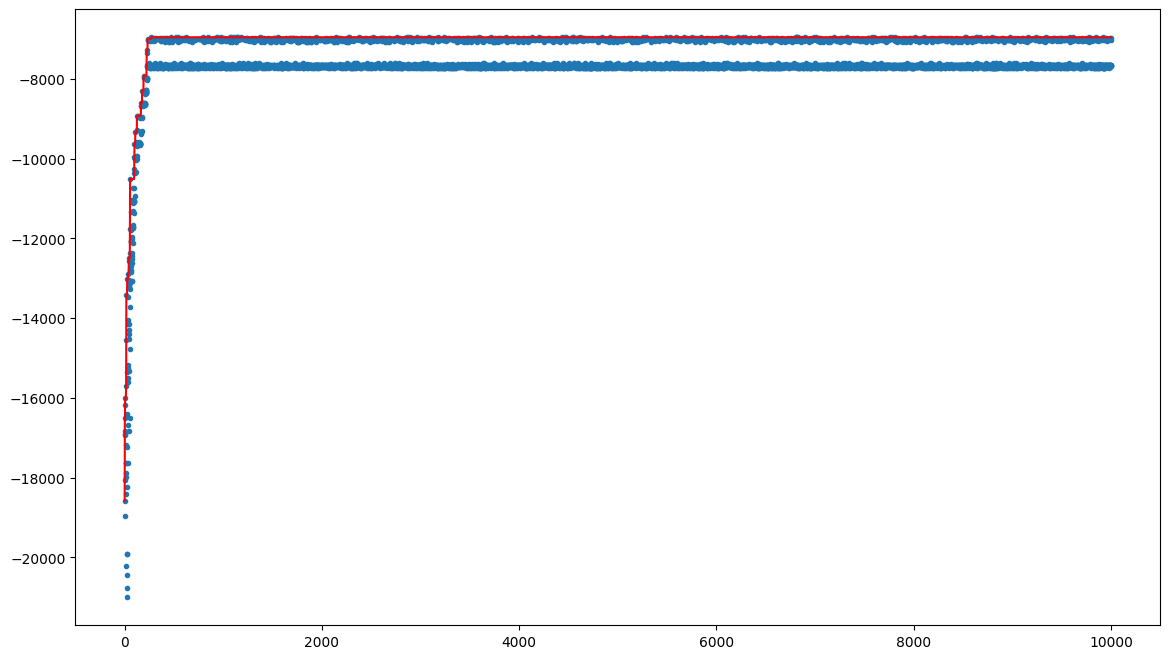

In [198]:
solution=common_solution.copy()
solution_fitness= fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))
strength= 0.3
buffer = list()
for steps in range(10000):
    new_solution = multiple_mutation_strength(solution,strength)
    f=fitness(new_solution)
    history.append(float(f[1]))
    buffer.append(f > solution_fitness)
    buffer = buffer[-5:]
    if sum(buffer) > 1:
        strength *= 1.2
    elif sum(buffer) == 0:
        strength /= 1.2

    if f > solution_fitness:
        solution = new_solution
        solution_fitness= fitness(solution)
    
ic(fitness(solution))

plt.figure(figsize=(14,8))
plt.plot(
    range(len(history)),
    list(accumulate(history,max)),
    color="red",
)
_= plt.scatter(range(len(history)),history,marker=".")

In [199]:
def simulated_annealing(solution: np.ndarray, steps: int, initial_temp: float = 40000, cooling_rate: float = 0.999):

    current_solution = solution.copy()

    current_fitness = fitness(current_solution)
    best_solution = current_solution
    best_fitness = current_fitness
    temperature=initial_temp
    buffer = list()
    history = [float(current_fitness[1])]
    best_history = [float(current_fitness[1])]  # usefull to track the best result history



    for step in range(steps):

        new_solution = single_mutation(current_solution)
        new_fitness = fitness(new_solution)

        #delta of the two last solutions found (used to calculate the probability of the new solution to be taken in case it is worse)
        delta_fitness = new_fitness[1] - current_fitness[1]


        if (delta_fitness > 0 and new_fitness[0]) or (new_fitness[0] and np.exp(delta_fitness / temperature) > rng.random()):
            current_solution = new_solution
            current_fitness = new_fitness


        if current_fitness > best_fitness:
            best_solution = current_solution
            best_fitness = current_fitness
            best_history.append( current_fitness[1])
        else:
            best_history.append(best_history[-1])

        buffer.append(current_fitness > best_fitness)
        buffer = buffer[-5:]
        if sum(buffer) > 1:
            cooling_rate *= 0.8
        elif sum(buffer) == 0:
            cooling_rate = min(cooling_rate/0.8, 0.999)


        temperature = max(temperature * cooling_rate, 0.001) 


        history.append(float(current_fitness[1]))   
        
    
    return best_solution, best_fitness, history, best_history

ic| fitness(common_solution): (np.True_, np.float64(-18581.76517007366))
ic| best_fitness: (np.True_, np.float64(-6634.967520367177))


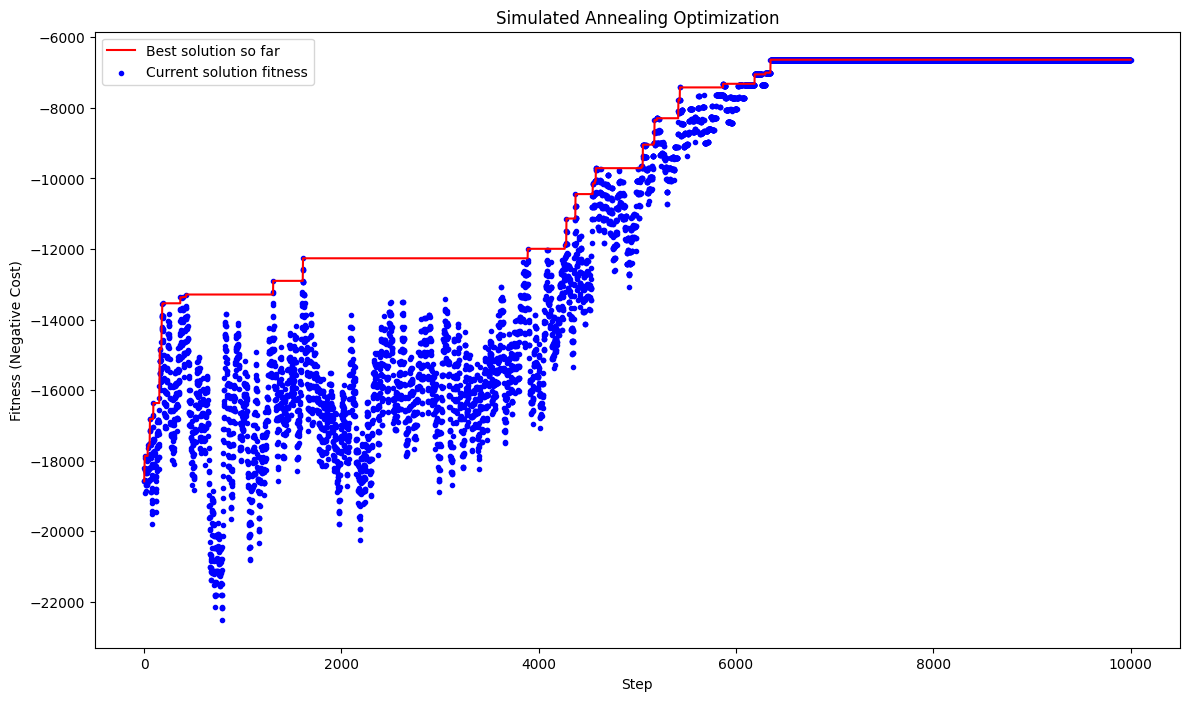

In [200]:

ic(fitness(common_solution))

best_solution, best_fitness, history, best_history = simulated_annealing(common_solution, steps=10000)
ic(best_fitness)

# Plotting
plt.figure(figsize=(14, 8))

plt.plot(
    range(len(best_history)),
    best_history,
    color="red",
    label="Best solution so far"
)

plt.scatter(
    range(len(history)),
    history,
    color="blue",
    marker=".",
    label="Current solution fitness"
)

plt.title("Simulated Annealing Optimization")
plt.xlabel("Step")
plt.ylabel("Fitness (Negative Cost)")
plt.legend()
plt.show()